Проведите RFM анализ
В каждом подсегменте поделите пользователей на 4 класса.
Отститывайте количество дней, прошедших с момента последней покупки,
с максимальной даты покупки в датасете

In [28]:
# импортирую необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
sns.set()

In [29]:
df = pd.read_csv("/home/jupyter-e.gorchakova-16/prod.analytics/RFM_ht_data.csv", parse_dates=["InvoiceDate"])

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
df.head()

InvoiceNo CustomerCode InvoiceDate   Amount
0  C0011810010001     19067290  2020-09-01  1716.00
1  C0011810010017     13233933  2020-09-01  1489.74
2  C0011810010020     99057968  2020-09-01   151.47
3  C0011810010021     80007276  2020-09-01   146.72
4  C0011810010024     13164076  2020-09-01   104.00

In [31]:
# этап предобработки данных
df.shape

(332730, 4)

In [32]:
df.loc[df.duplicated()]

Empty DataFrame
Columns: [InvoiceNo, CustomerCode, InvoiceDate, Amount]
Index: []

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     332730 non-null  object        
 1   CustomerCode  332730 non-null  object        
 2   InvoiceDate   332730 non-null  datetime64[ns]
 3   Amount        332730 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.2+ MB


In [34]:
# чтобы не пропустить значения типа int, привожу значения колонки к типу:строка
df["CustomerCode"] = df["CustomerCode"].apply(str)
df["InvoiceNo"] = df["InvoiceNo"].apply(str)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     332730 non-null  object        
 1   CustomerCode  332730 non-null  object        
 2   InvoiceDate   332730 non-null  datetime64[ns]
 3   Amount        332730 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.2+ MB


In [36]:
# оцениваю за какой временной промежуток выгружены данные- за сентябрь 2020г
df.InvoiceDate.describe()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                  332730
unique                     30
top       2020-09-30 00:00:00
freq                    19781
first     2020-09-01 00:00:00
last      2020-09-30 00:00:00
Name: InvoiceDate, dtype: object

In [37]:
# отдельно выделяю последниюю дату датасета, т.к необходимо будет посчитать разницу по времени
last_date = df["InvoiceDate"].max()

In [38]:
last_date

Timestamp('2020-09-30 00:00:00')

In [39]:
df.head()

InvoiceNo CustomerCode InvoiceDate   Amount
0  C0011810010001     19067290  2020-09-01  1716.00
1  C0011810010017     13233933  2020-09-01  1489.74
2  C0011810010020     99057968  2020-09-01   151.47
3  C0011810010021     80007276  2020-09-01   146.72
4  C0011810010024     13164076  2020-09-01   104.00

In [40]:
# для каждого пользователя посчитаем разницу по времени между last_date датой последней покупки,
# количество заказов,
# выручка на пользователя 
rfmTable = df\
    .groupby("CustomerCode", as_index=False)\
    .agg({"InvoiceDate": lambda x: (last_date - x.max()).days,
          "InvoiceNo": lambda x: len(x), 
          "Amount": lambda x: x.sum()})
rfmTable.rename(columns={"InvoiceDate": "recency", "InvoiceNo": "frequency", "Amount": "monetary_value"}, inplace=True)
rfmTable["recency"] = rfmTable["recency"].astype(int)

In [41]:
rfmTable.head()

CustomerCode  recency  frequency  monetary_value
0     02213019       19          1         1609.20
1     02213042       22          3         9685.48
2     02213071       29          1          415.00
3     02213088       23          1          305.00
4     02213092       25          1         1412.88

In [42]:
# определим  0.25, 0.5, 0.75 по каждому параметру
quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])

In [43]:
quantiles

recency  frequency  monetary_value
0.25      2.0        1.0          765.00
0.50      8.0        2.0         1834.48
0.75     16.0        3.0         4008.84

In [44]:
# пропишем функции для RFM анализа(с 1 по 4- от лучшего к худшему)
def RClass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [45]:
rfmSegmentation = rfmTable

In [46]:
# добавим колонку, к какому подсегменту принадлежит конкретный пользователь
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency', quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency', quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value', quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) + rfmSegmentation.F_Quartile.map(str) + rfmSegmentation.M_Quartile.map(str)

In [47]:
rfmSegmentation.head()

CustomerCode  recency  frequency  monetary_value  R_Quartile  F_Quartile  \
0     02213019       19          1         1609.20           4           4   
1     02213042       22          3         9685.48           4           2   
2     02213071       29          1          415.00           4           4   
3     02213088       23          1          305.00           4           4   
4     02213092       25          1         1412.88           4           4   

   M_Quartile RFMClass  
0           3      443  
1           1      421  
2           4      444  
3           4      444  
4           3      443

In [48]:
# проверяем совпадает ли кол-во строк в получившимся датафрейме с кол-вом покупателей в изначальном датасете
rfmSegmentation.shape

(123733, 8)

In [49]:
df.CustomerCode.nunique()

123733

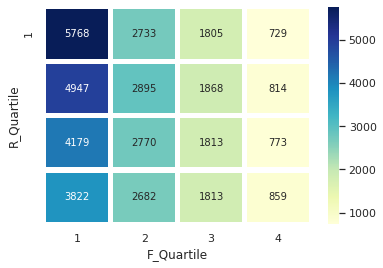

In [50]:
# преобразуем данные: колонка- сортировка по  частоте заказов, строка - разница по времени от last_date
# добавим визуализацию,  значения в каждой ячейке -медианное значение выручки
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

In [51]:
rfmSegmentation.head()

CustomerCode  recency  frequency  monetary_value  R_Quartile  F_Quartile  \
0     02213019       19          1         1609.20           4           4   
1     02213042       22          3         9685.48           4           2   
2     02213071       29          1          415.00           4           4   
3     02213088       23          1          305.00           4           4   
4     02213092       25          1         1412.88           4           4   

   M_Quartile RFMClass  
0           3      443  
1           1      421  
2           4      444  
3           4      444  
4           3      443

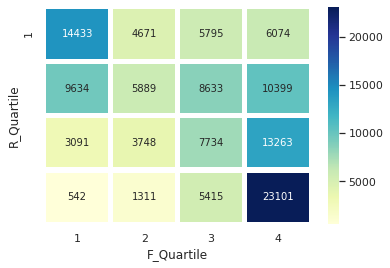

In [52]:
# теперь в ячейке стоит кол-во уникальных пользователей в каждом подсегменте
rfm_table_id = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='CustomerCode', 
                        aggfunc=lambda x:x.nunique()).applymap(int)
sns.heatmap(rfm_table_id, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);